In [2]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json

In [24]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    wind_speeds = []

    for path in paths:
        wind_speeds = np.append(wind_speeds, int(path['maxwind']))

    highest_wind = max(wind_speeds)
    
    return highest_wind

def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    precips.sort()
    imerg_array = np.load(precips[0])
    
    for file in precips[1:10]:
        load = np.load(file)
        print(file, load.shape)
        imerg_array = np.append(imerg_array, load, axis = 0)
    imerg_array = imerg_array.reshape(1, 10, 100, 100)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    temperatures.sort()
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 100, 100)
    
    return sst_array

def get_rgb(rgb):
    # get wavelet decomposed rgb
    colors = glob.glob(rgb, recursive = True)
    colors.sort()
    rgb_array = np.load(colors[0])
    
    for file in colors[1:4]:
        rgb_array = np.append(rgb_array, np.load(file), axis = 0)
    
    rgb_array = rgb_array[:, :100, :100]
    rgb_array = rgb_array.reshape(1, 48, 100, 100)
    
    return rgb_array

def lenCheck(imerg, sst, rgb):
    imergs = glob.glob(imerg)
    ssts = glob.glob(sst)
    rgbs = glob.glob(rgb)
    
    if len(imergs) < 10 or len(ssts) < 4 or len(rgbs) < 4:
        return False
    else:
        return True
    
def landCheck(folder, imerg, sst, rgb):
    name = folder + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']

    valid_dates = []
    for path in paths:
        valid_dates = np.append(valid_dates, str(path['date']))
        
    file = folder + '/imerg_precipitation_*.npy'

    imergs = glob.glob(file, recursive = True)
    imergs.sort()
    imergs = imergs[0:4]
    
    valid = True

    days = []

    for imerg in imergs:
        days = np.append(days, imerg[-17:-9])

    for day in days:
        if day not in valid_dates:
            valid = False
        else:
            valid = True

    return valid
    

In [25]:
highest_wind = np.empty([0])
imerg_precip = np.empty([1, 10, 100, 100])
skin_temp = np.empty([1, 4, 100, 100])
dwt_rgb = np.empty([1, 48, 100, 100])

all_folders = glob.glob('/home/fun/data/AL*20*')
all_folders.sort()

len_fail = 0
land_fail = 0

for folder in all_folders:
    imerg_names = folder + '/imerg_precipitation_*.npy'
    sst_names = folder + '/noaa_sst_*.npy'
    rgb_names = folder + '/wavelet_rgb_*.npy'
    
    if not lenCheck(imerg_names, sst_names, rgb_names):
        print("skipping lenCheck ", folder)
        len_fail += 1
        continue
    if not landCheck(folder, imerg_names, sst_names, rgb_names):
        print("skipping landCheck ", folder)
        land_fail += 1
        continue
    
    imerg_precip = np.append(imerg_precip, get_imerg(imerg_names), axis = 0) # X data (train class)
    skin_temp = np.append(skin_temp, get_sst(sst_names), axis = 0) # X data (train class)
    dwt_rgb = np.append(dwt_rgb, get_rgb(rgb_names), axis = 0)
    
    highest_wind = np.append(highest_wind, get_max_wind(folder)) # Y data (target class)

imerg_precip = imerg_precip[1:]
skin_temp = skin_temp[1:]
dwt_rgb = dwt_rgb[1:]
    
print(imerg_precip.shape, skin_temp.shape, dwt_rgb.shape, highest_wind.shape)
print("len_fail: ", len_fail)
print("land_fail: ", land_fail)

skipping lenCheck  /home/fun/data/AL012000
skipping landCheck  /home/fun/data/AL012001
/home/fun/data/AL012002/imerg_precipitation_20020715_0000.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020715_0600.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020715_1200.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020715_1800.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020716_0000.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020716_0600.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020716_1200.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020716_1800.npy (1, 1, 100, 100)
/home/fun/data/AL012002/imerg_precipitation_20020717_0000.npy (1, 1, 100, 100)
/home/fun/data/AL012003/imerg_precipitation_20030418_0600.npy (1, 1, 100, 100)
/home/fun/data/AL012003/imerg_precipitation_20030418_1200.npy (1, 1, 100, 100)
/home/fun/data/AL012003/imerg_precipitation_

/home/fun/data/AL012017/imerg_precipitation_20170416_1200.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170416_1800.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170417_0000.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170417_0600.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170417_1200.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170417_1800.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170418_0000.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170418_0600.npy (1, 1, 100, 100)
/home/fun/data/AL012017/imerg_precipitation_20170418_1200.npy (1, 1, 100, 100)
/home/fun/data/AL012018/imerg_precipitation_20180525_1800.npy (1, 1, 100, 100)
/home/fun/data/AL012018/imerg_precipitation_20180526_0000.npy (1, 1, 100, 100)
/home/fun/data/AL012018/imerg_precipitation_20180526_0600.npy (1, 1, 100, 100)
/home/fun/data/AL012018/imerg_precipitation_20180526

/home/fun/data/AL022016/imerg_precipitation_20160527_1200.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160527_1800.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160528_0000.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160528_0600.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160528_1200.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160528_1800.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160529_0000.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160529_0600.npy (1, 1, 100, 100)
/home/fun/data/AL022016/imerg_precipitation_20160529_1200.npy (1, 1, 100, 100)
skipping lenCheck  /home/fun/data/AL022017
/home/fun/data/AL022018/imerg_precipitation_20180704_1800.npy (1, 1, 100, 100)
/home/fun/data/AL022018/imerg_precipitation_20180705_0000.npy (1, 1, 100, 100)
/home/fun/data/AL022018/imerg_precipitation_20180705_0600.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL032012/imerg_precipitation_20120617_0600.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120617_1200.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120617_1800.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120618_0000.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120618_0600.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120618_1200.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120618_1800.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120619_0000.npy (1, 1, 100, 100)
/home/fun/data/AL032012/imerg_precipitation_20120619_0600.npy (1, 1, 100, 100)
/home/fun/data/AL032013/imerg_precipitation_20130707_1800.npy (1, 1, 100, 100)
/home/fun/data/AL032013/imerg_precipitation_20130708_0000.npy (1, 1, 100, 100)
/home/fun/data/AL032013/imerg_precipitation_20130708_0600.npy (1, 1, 100, 100)
/home/fun/data/AL032013/imerg_precipitation_20130708

skipping lenCheck  /home/fun/data/AL042009
/home/fun/data/AL042010/imerg_precipitation_20100802_1800.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100803_0000.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100803_0600.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100803_1200.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100803_1800.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100804_0000.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100804_0600.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100804_1200.npy (1, 1, 100, 100)
/home/fun/data/AL042010/imerg_precipitation_20100804_1800.npy (1, 1, 100, 100)
/home/fun/data/AL042011/imerg_precipitation_20110727_1200.npy (1, 1, 100, 100)
/home/fun/data/AL042011/imerg_precipitation_20110727_1800.npy (1, 1, 100, 100)
/home/fun/data/AL042011/imerg_precipitation_20110728_0000.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL052008/imerg_precipitation_20080803_1800.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080804_0000.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080804_0600.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080804_1200.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080804_1800.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080805_0000.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080805_0600.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080805_1200.npy (1, 1, 100, 100)
/home/fun/data/AL052008/imerg_precipitation_20080805_1800.npy (1, 1, 100, 100)
/home/fun/data/AL052009/imerg_precipitation_20090826_1200.npy (1, 1, 100, 100)
/home/fun/data/AL052009/imerg_precipitation_20090826_1800.npy (1, 1, 100, 100)
/home/fun/data/AL052009/imerg_precipitation_20090827_0000.npy (1, 1, 100, 100)
/home/fun/data/AL052009/imerg_precipitation_20090827

/home/fun/data/AL062006/imerg_precipitation_20060825_0000.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060825_0600.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060825_1200.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060825_1800.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060826_0000.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060826_0600.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060826_1200.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060826_1800.npy (1, 1, 100, 100)
/home/fun/data/AL062006/imerg_precipitation_20060827_0000.npy (1, 1, 100, 100)
/home/fun/data/AL062007/imerg_precipitation_20070831_1800.npy (1, 1, 100, 100)
/home/fun/data/AL062007/imerg_precipitation_20070901_0000.npy (1, 1, 100, 100)
/home/fun/data/AL062007/imerg_precipitation_20070901_0600.npy (1, 1, 100, 100)
/home/fun/data/AL062007/imerg_precipitation_20070901

skipping lenCheck  /home/fun/data/AL072005
/home/fun/data/AL072006/imerg_precipitation_20060904_0000.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060904_0600.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060904_1200.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060904_1800.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060905_0000.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060905_0600.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060905_1200.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060905_1800.npy (1, 1, 100, 100)
/home/fun/data/AL072006/imerg_precipitation_20060906_0000.npy (1, 1, 100, 100)
/home/fun/data/AL072007/imerg_precipitation_20070908_0600.npy (1, 1, 100, 100)
/home/fun/data/AL072007/imerg_precipitation_20070908_1200.npy (1, 1, 100, 100)
/home/fun/data/AL072007/imerg_precipitation_20070908_1800.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL082003/imerg_precipitation_20030815_0000.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030815_0600.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030815_1200.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030815_1800.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030816_0000.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030816_0600.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030816_1030.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030816_1200.npy (1, 1, 100, 100)
/home/fun/data/AL082003/imerg_precipitation_20030816_1800.npy (1, 1, 100, 100)
/home/fun/data/AL082004/imerg_precipitation_20040828_0000.npy (1, 1, 100, 100)
/home/fun/data/AL082004/imerg_precipitation_20040828_0600.npy (1, 1, 100, 100)
/home/fun/data/AL082004/imerg_precipitation_20040828_1200.npy (1, 1, 100, 100)
/home/fun/data/AL082004/imerg_precipitation_20040828

skipping lenCheck  /home/fun/data/AL092003
/home/fun/data/AL092004/imerg_precipitation_20040903_0000.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040903_0600.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040903_1200.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040903_1800.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040904_0000.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040904_0600.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040904_1200.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040904_1800.npy (1, 1, 100, 100)
/home/fun/data/AL092004/imerg_precipitation_20040905_0000.npy (1, 1, 100, 100)
/home/fun/data/AL092005/imerg_precipitation_20050805_0000.npy (1, 1, 100, 100)
/home/fun/data/AL092005/imerg_precipitation_20050805_0600.npy (1, 1, 100, 100)
/home/fun/data/AL092005/imerg_precipitation_20050805_1200.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL102002/imerg_precipitation_20020915_0000.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020915_0600.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020915_1200.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020915_1800.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020916_0000.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020916_0600.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020916_1200.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020916_1800.npy (1, 1, 100, 100)
/home/fun/data/AL102002/imerg_precipitation_20020917_0000.npy (1, 1, 100, 100)
/home/fun/data/AL102003/imerg_precipitation_20030828_0000.npy (1, 1, 100, 100)
/home/fun/data/AL102003/imerg_precipitation_20030828_0600.npy (1, 1, 100, 100)
/home/fun/data/AL102003/imerg_precipitation_20030828_1200.npy (1, 1, 100, 100)
/home/fun/data/AL102003/imerg_precipitation_20030828

skipping lenCheck  /home/fun/data/AL112002
/home/fun/data/AL112003/imerg_precipitation_20030830_1800.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030831_0000.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030831_0600.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030831_1100.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030831_1200.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030831_1800.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030901_0000.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030901_0600.npy (1, 1, 100, 100)
/home/fun/data/AL112003/imerg_precipitation_20030901_1200.npy (1, 1, 100, 100)
/home/fun/data/AL112004/imerg_precipitation_20040914_0000.npy (1, 1, 100, 100)
/home/fun/data/AL112004/imerg_precipitation_20040914_0400.npy (1, 1, 100, 100)
/home/fun/data/AL112004/imerg_precipitation_20040914_0600.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL122005/imerg_precipitation_20050824_0000.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050824_0600.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050824_1200.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050824_1800.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050825_0000.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050825_0600.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050825_1200.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050825_1800.npy (1, 1, 100, 100)
/home/fun/data/AL122005/imerg_precipitation_20050825_2230.npy (1, 1, 100, 100)
/home/fun/data/AL122007/imerg_precipitation_20070925_0600.npy (1, 1, 100, 100)
/home/fun/data/AL122007/imerg_precipitation_20070925_1200.npy (1, 1, 100, 100)
/home/fun/data/AL122007/imerg_precipitation_20070925_1800.npy (1, 1, 100, 100)
/home/fun/data/AL122007/imerg_precipitation_20070926

/home/fun/data/AL132007/imerg_precipitation_20070926_0000.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070926_0600.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070926_1200.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070926_1800.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070927_0000.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070927_0600.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070927_1200.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070927_1800.npy (1, 1, 100, 100)
/home/fun/data/AL132007/imerg_precipitation_20070928_0000.npy (1, 1, 100, 100)
skipping lenCheck  /home/fun/data/AL132008
/home/fun/data/AL132010/imerg_precipitation_20100914_0000.npy (1, 1, 100, 100)
/home/fun/data/AL132010/imerg_precipitation_20100914_0600.npy (1, 1, 100, 100)
/home/fun/data/AL132010/imerg_precipitation_20100914_1200.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL142011/imerg_precipitation_20110907_0000.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110907_0600.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110907_1200.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110907_1800.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110908_0000.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110908_0600.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110908_1200.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110908_1800.npy (1, 1, 100, 100)
/home/fun/data/AL142011/imerg_precipitation_20110909_0000.npy (1, 1, 100, 100)
/home/fun/data/AL142012/imerg_precipitation_20120910_1800.npy (1, 1, 100, 100)
/home/fun/data/AL142012/imerg_precipitation_20120911_0000.npy (1, 1, 100, 100)
/home/fun/data/AL142012/imerg_precipitation_20120911_0600.npy (1, 1, 100, 100)
/home/fun/data/AL142012/imerg_precipitation_20120911

skipping lenCheck  /home/fun/data/AL162001
/home/fun/data/AL162003/imerg_precipitation_20030926_0000.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030926_0600.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030926_1200.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030926_1800.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030927_0000.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030927_0600.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030927_1200.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030927_1800.npy (1, 1, 100, 100)
/home/fun/data/AL162003/imerg_precipitation_20030928_0000.npy (1, 1, 100, 100)
/home/fun/data/AL162004/imerg_precipitation_20041126_0600.npy (1, 1, 100, 100)
/home/fun/data/AL162004/imerg_precipitation_20041126_1200.npy (1, 1, 100, 100)
/home/fun/data/AL162004/imerg_precipitation_20041126_1800.npy (1, 1, 100, 100)
/home/fun

/home/fun/data/AL172008/imerg_precipitation_20081106_0000.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081106_0600.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081106_1200.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081106_1800.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081107_0000.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081107_0600.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081107_1200.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081107_1800.npy (1, 1, 100, 100)
/home/fun/data/AL172008/imerg_precipitation_20081108_0000.npy (1, 1, 100, 100)
/home/fun/data/AL172010/imerg_precipitation_20101006_1200.npy (1, 1, 100, 100)
/home/fun/data/AL172010/imerg_precipitation_20101006_1800.npy (1, 1, 100, 100)
/home/fun/data/AL172010/imerg_precipitation_20101007_0000.npy (1, 1, 100, 100)
/home/fun/data/AL172010/imerg_precipitation_20101007

skipping lenCheck  /home/fun/data/AL192005
/home/fun/data/AL192010/imerg_precipitation_20101020_0000.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101020_0600.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101020_1200.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101020_1800.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101021_0000.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101021_0600.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101021_1200.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101021_1800.npy (1, 1, 100, 100)
/home/fun/data/AL192010/imerg_precipitation_20101022_0000.npy (1, 1, 100, 100)
/home/fun/data/AL192011/imerg_precipitation_20111106_0600.npy (1, 1, 100, 100)
/home/fun/data/AL192011/imerg_precipitation_20111106_1200.npy (1, 1, 100, 100)
/home/fun/data/AL192011/imerg_precipitation_20111106_1800.npy (1, 1, 100, 100)
/home/fun

skipping lenCheck  /home/fun/data/AL272020
/home/fun/data/AL282005/imerg_precipitation_20051114_0600.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051114_1200.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051114_1800.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051115_0000.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051115_0600.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051115_1200.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051115_1800.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051116_0000.npy (1, 1, 100, 100)
/home/fun/data/AL282005/imerg_precipitation_20051116_0600.npy (1, 1, 100, 100)
skipping lenCheck  /home/fun/data/AL282020
/home/fun/data/AL292005/imerg_precipitation_20051119_1800.npy (1, 1, 100, 100)
/home/fun/data/AL292005/imerg_precipitation_20051120_0000.npy (1, 1, 100, 100)
/home/fun/data/AL292005/imerg_precipitation_2

In [26]:
final = np.append(imerg_precip, skin_temp, axis = 1)
final = np.append(final, dwt_rgb, axis = 1)
final.shape

(216, 62, 100, 100)

In [27]:
for i in range(final.shape[0]):
    for j in range(final.shape[1]):
        scaler = StandardScaler()
        scaler.fit(final[i, j, :, :])
        final[i, j, :, :] = scaler.transform(final[i, j, :, :])
        
final

array([[[[ 1.02679073e+00, -1.04133045e-01,  9.81436018e-01, ...,
          -3.43032459e-01, -3.43791077e-01, -2.72049944e-01],
         [-2.17097913e-01, -2.72833745e-01,  1.59773917e+00, ...,
          -3.43032459e-01, -3.43791077e-01, -2.72049944e-01],
         [-2.17097913e-01, -2.72833745e-01,  1.72870909e-01, ...,
          -3.43032459e-01, -3.43791077e-01, -2.72049944e-01],
         ...,
         [-2.17097913e-01, -2.72833745e-01, -3.48529571e-01, ...,
          -3.43032459e-01, -3.43791077e-01, -2.72049944e-01],
         [-2.17097913e-01, -2.72833745e-01, -3.48529571e-01, ...,
          -3.43032459e-01, -3.43791077e-01, -2.72049944e-01],
         [-2.17097913e-01, -2.72833745e-01, -3.48529571e-01, ...,
          -3.43032459e-01, -3.43791077e-01, -2.72049944e-01]],

        [[-4.59499547e-01, -3.92268003e-01, -3.69911895e-01, ...,
          -2.65204375e-01, -1.85336608e-01, -1.99952077e-01],
         [-4.59499547e-01, -3.92268003e-01, -3.69911895e-01, ...,
          -2.65204375e

In [28]:
final = final.astype("float32")
highest_wind = highest_wind.astype("float32")

final = np.swapaxes(final, 1, 2)
final = np.swapaxes(final, 2, 3)
final.shape

(216, 100, 100, 62)

In [29]:
# img
X_train, X_test, y_train, y_test = train_test_split(
    final, highest_wind, train_size = 0.8, random_state = 18778)


print(X_train.shape, y_train.shape)
print(y_train, y_test)

(172, 100, 100, 62) (172,)
[ 75.  75.  40.  90.  90.  50.  70.  55.  50. 120.  70.  50.  50.  50.
  45.  55.  35.  55. 125.  25. 125. 160.  50.  70. 105.  30.  65.  60.
 110.  25.  45. 120.  35. 150.  45.  60. 100.  45.  75.  55. 125.  50.
  50.  45. 105.  75. 100. 110.  85.  55. 120. 105.  30.  35.  55.  50.
 120.  85.  40.  55.  90.  50.  55. 110.  60.  55.  50.  55.  40.  35.
  60.  50.  40.  35.  60. 145. 145.  45.  75.  65.  45.  40.  50.  85.
  75.  90.  40.  90.  70.  75.  55. 125.  45. 100.  45.  30. 110.  70.
  35.  40.  40.  70. 155.  50.  80. 120.  40.  30.  65. 135.  85.  75.
  55.  55.  65.  50.  30.  60.  75.  45.  35. 115.  45.  40.  90.  55.
  60.  45.  35.  55.  65.  50.  65.  80.  45.  45.  60.  40. 105.  55.
  30.  70.  45.  60.  60.  40.  65.  80.  60.  55.  45.  80.  70.  50.
  75.  70.  55.  75.  60.  80.  80.  80.  65.  80.  55.  95.  50. 125.
  55.  50.  70.  50.] [105.  50. 115.  30.  55.  35.  60.  35.  55.  55.  55.  60. 125.  95.
  50.  60.  50.  60.  30. 11

In [52]:
# stage 1 of hurricane development -- early input data
stage1_input = Input(shape = (100, 100, 3),
                      name = 'stage1_input')

stage1_conv1 = Conv2D(filters = 3, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage1_conv1')(stage1_input)

stage1_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage1_pool1')(stage1_conv1)

stage1_batch1 = BatchNormalization(name = 'stage1_batch1')(stage1_pool1)

stage1_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage1_conv2')(stage1_batch1)

stage1_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage1_pool2')(stage1_conv2)

stage1_batch2 = BatchNormalization(name = 'stage1_batch2')(stage1_pool2)

stage1_flat = Flatten(name = 'stage1_flat')(stage1_batch2)


# stage 2

stage2_input = Input(shape = (100, 100, 3),
                      name = 'stage2_input')

stage2_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage2_conv1')(stage2_input)

stage2_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage2_pool1')(stage2_conv1)

stage2_batch1 = BatchNormalization(name = 'stage2_batch1')(stage2_pool1)

stage2_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage2_conv2')(stage2_batch1)

stage2_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage2_pool2')(stage2_conv2)

stage2_batch2 = BatchNormalization(name = 'stage2_batch2')(stage2_pool2)

stage2_flat = Flatten(name = 'stage2_flat')(stage2_batch2)

# stage 3

stage3_input = Input(shape = (100, 100, 3),
                      name = 'stage3_input')

stage3_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage3_conv1')(stage3_input)

stage3_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage3_pool1')(stage3_conv1)

stage3_batch1 = BatchNormalization(name = 'stage3_batch1')(stage3_pool1)

stage3_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage3_conv2')(stage3_batch1)

stage3_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage3_pool2')(stage3_conv2)

stage3_batch2 = BatchNormalization(name = 'stage3_batch2')(stage3_pool2)

stage3_flat = Flatten(name = 'stage3_flat')(stage3_batch2)


# stage 4 of hurricane development -- latest stage just before it makes contact with land

stage4_input = Input(shape = (100, 100, 3),
                      name = 'stage4_input')

stage4_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage4_conv1')(stage4_input)

stage4_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage4_pool1')(stage4_conv1)

stage4_batch1 = BatchNormalization(name = 'stage4_batch1')(stage4_pool1)

stage4_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage4_conv2')(stage4_batch1)

stage4_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage4_pool2')(stage4_conv2)

stage4_batch2 = BatchNormalization(name = 'stage4_batch2')(stage4_pool2)

stage4_flat = Flatten(name = 'stage4_flat')(stage4_batch2)


# dense layers -- feature training

concat = concatenate([stage1_flat, stage2_flat, stage3_flat, stage4_flat])

dense1 = Dense(128, activation = 'relu', name = 'Fully_Connected_1')(concat)
dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

dense2 = Dense(64, activation = 'relu', name = 'Fully_Connected_2')(dense1dropout)
dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

output = Dense(1, activation = 'relu', name = 'Output_Layer')(dense2dropout)

# create model with two inputs
model = Model([stage1_input, stage2_input, stage3_input, stage4_input], output)

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stage1_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stage2_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stage3_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stage4_input (InputLayer)       [(None, 100, 100, 3) 0                                            
___________________________________________________________________________________________

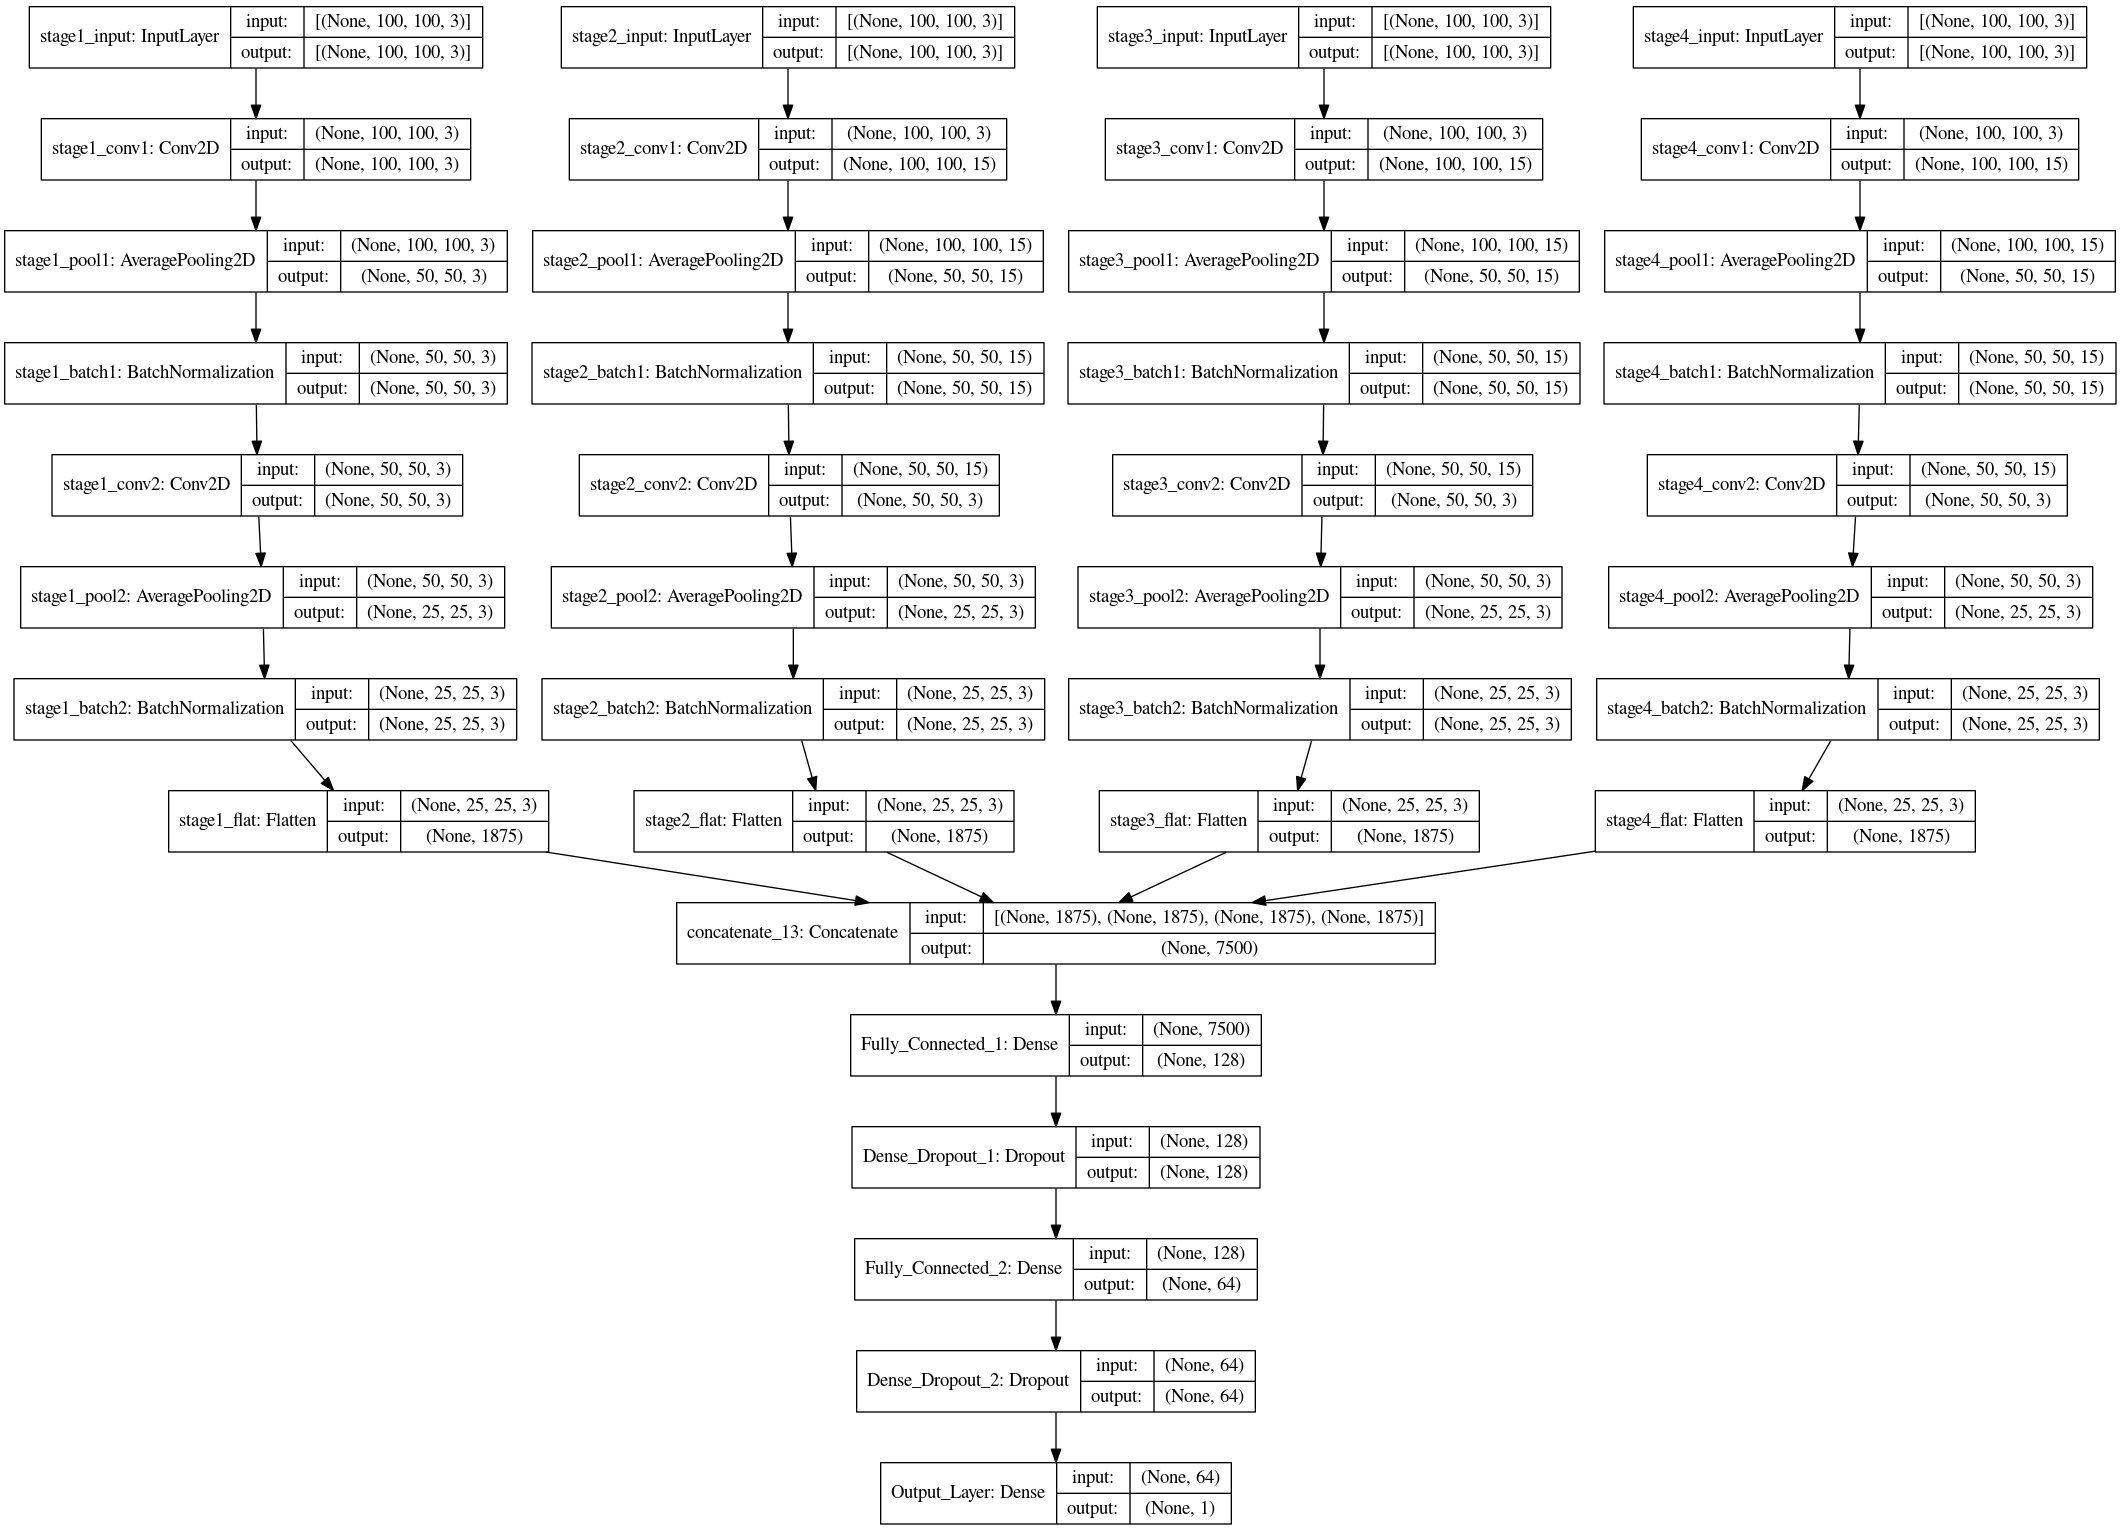

In [53]:
tf.keras.utils.plot_model(model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/10
35/35 [==============================] - 26s 716ms/step - loss: 3229.1785 - root_mean_squared_error: 56.8259 - val_loss: 2931.5369 - val_root_mean_squared_error: 54.1437
Epoch 2/10
35/35 [==============================] - 25s 708ms/step - loss: 2741.6096 - root_mean_squared_error: 52.3604 - val_loss: 1961.9039 - val_root_mean_squared_error: 44.2934
Epoch 3/10
35/35 [==============================] - 25s 710ms/step - loss: 2518.3879 - root_mean_squared_error: 50.1835 - val_loss: 2905.4595 - val_root_mean_squared_error: 53.9023
Epoch 4/10
35/35 [==============================] - 25s 709ms/step - loss: 1768.4930 - root_mean_squared_error: 42.0535 - val_loss: 867.9095 - val_root_mean_squared_error: 29.4603
Epoch 5/10
35/35 [==============================] - 25s 710ms/step - loss: 2193.6907 - root_mean_squared_error: 46.8369 - val_loss: 1099.8230 - val_root_mean_squared_error: 33.1636
Epoch 6/10
35/35 [==============================] - 25s 710ms/step - loss: 1694.2200 - root_mean

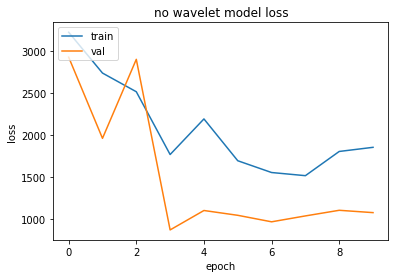

In [32]:
model.compile(
    loss = keras.losses.MeanSquaredError(), 
    optimizer = "adam",
    metrics = tf.keras.metrics.RootMeanSquaredError()
)

history = model.fit([X_train], y_train, 
          batch_size = 5, 
          epochs = 10, 
          validation_data = ([X_test], y_test), 
          )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('no wavelet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

[105.  50. 115.  30.  55.  35.  60.  35.  55.  55.  55.  60. 125.  95.
  50.  60.  50.  60.  30. 115. 100.  55.  50. 100.  45. 105.  70.  65.
  75. 120.  40.  40.  75.  80.  80.  50.  45.  50.  50.  60.  45. 125.
  55.  35.]
[81.68984  40.34901  54.3999   57.168728 28.487864 61.39249  83.49641
 69.721825 26.372568 25.110533 55.9846   42.709057 79.03939  47.15066
 71.28166  60.450344 66.218475 26.84889  43.904552 62.363064 54.742584
 65.265686 47.881893 60.452587 48.399464 33.296036 40.44173  54.560867
 42.188877 37.75932  53.324314 59.900043 40.168407 76.77233  31.378103
 21.14361  40.647915 70.12118  60.689457 32.96297  50.975094 68.568756
 45.777622 59.70582 ]


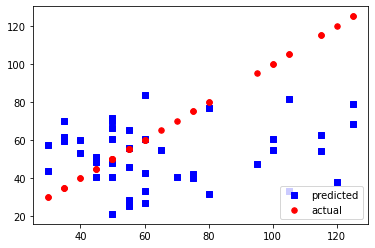

In [33]:
y_pred = model.predict([X_test])
y_pred = y_pred.reshape(y_pred.shape[0])

print(y_test)
print(y_pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y_test, y_pred, s=30, c='b', marker="s", label='predicted')
ax1.scatter(y_test, y_test, s=30, c='r', marker="o", label='actual')
plt.legend(loc='lower right')
plt.show()

[ 75.  75.  40.  90.  90.  50.  70.  55.  50. 120.  70.  50.  50.  50.
  45.  55.  35.  55. 125.  25. 125. 160.  50.  70. 105.  30.  65.  60.
 110.  25.  45. 120.  35. 150.  45.  60. 100.  45.  75.  55. 125.  50.
  50.  45. 105.  75. 100. 110.  85.  55. 120. 105.  30.  35.  55.  50.
 120.  85.  40.  55.  90.  50.  55. 110.  60.  55.  50.  55.  40.  35.
  60.  50.  40.  35.  60. 145. 145.  45.  75.  65.  45.  40.  50.  85.
  75.  90.  40.  90.  70.  75.  55. 125.  45. 100.  45.  30. 110.  70.
  35.  40.  40.  70. 155.  50.  80. 120.  40.  30.  65. 135.  85.  75.
  55.  55.  65.  50.  30.  60.  75.  45.  35. 115.  45.  40.  90.  55.
  60.  45.  35.  55.  65.  50.  65.  80.  45.  45.  60.  40. 105.  55.
  30.  70.  45.  60.  60.  40.  65.  80.  60.  55.  45.  80.  70.  50.
  75.  70.  55.  75.  60.  80.  80.  80.  65.  80.  55.  95.  50. 125.
  55.  50.  70.  50.]
[ 54.78083   64.08579   77.192955  55.702915  49.749214  50.849373
  36.8649    49.600574  61.441868 105.380875  85.27045   40

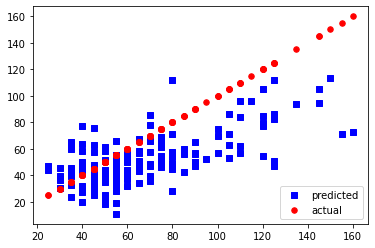

In [34]:
train_pred = model.predict(X_train)
train_pred = train_pred.reshape(train_pred.shape[0])

print(y_train)
print(train_pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y_train, train_pred, s=30, c='b', marker="s", label='predicted')
ax1.scatter(y_train, y_train, s=30, c='r', marker="o", label='actual')
plt.legend(loc='lower right')
plt.show()

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

NameError: name 'y_test_spatial' is not defined

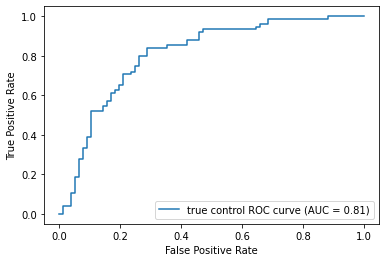

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='true control ROC curve')
display.plot()

plt.show()

In [34]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("true control confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

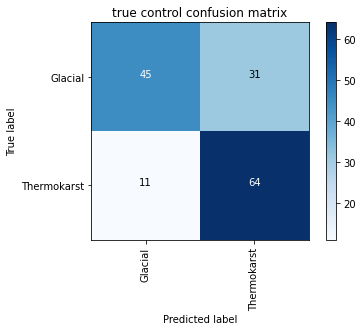

In [35]:
draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()

In [19]:
import json

name = '/home/fun/data/AL202003' + '/profile.json'
f = open(name)
profile = json.load(f)
paths = profile['path']

valid_dates = []
for path in paths:
    valid_dates = np.append(valid_dates, str(path['date']))
    
imergs = glob.glob('/home/fun/data/AL182012/imerg_precipitation_*.npy', recursive = True)
imergs.sort()
imergs = imergs[0:3]
print(len(imergs))

valid = True

days = []

for imerg in imergs:
    days = np.append(days, imerg[-17:-9])
    
for day in days:
    if day not in valid_dates:
        valid = False
        
print(valid, valid_dates, days)

3
False ['20031204' '20031204' '20031205' '20031205' '20031205' '20031205'
 '20031206' '20031206' '20031206' '20031206'] ['20121021' '20121022' '20121022']
